In [1]:
# --- Imports ---
import datetime as dt
import sys,os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sns
import re
import os
from scipy import stats
from pylab import *
from sklearn.neighbors import KernelDensity
%matplotlib inline

import requests
from bs4 import BeautifulSoup

    

In [2]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3445097/

In [3]:
# Create a variable with the URL to this tutorial
url = 'http://www.prosportstransactions.com/basketball/Search/SearchResults.php?Player=&Team=&BeginDate=2001-09-12&EndDate=2016-11-21&InjuriesChkBx=yes&Submit=Search'
# Scrape the HTML at the url
r = requests.get(url)

# Turn the HTML into a Beautiful Soup object
soup = BeautifulSoup(r.text, 'lxml')

In [4]:
def getsoup(page_no):
    start_at = str(int(page_no*25))
    url_page = url+'&start='+start_at
    
    r = requests.get(url_page)
    
    soup = BeautifulSoup(r.text,'lxml')
    table = soup.find(class_='datatable center')
    
    return table

def table_injuries(table):
    date = []
    team = []
    aquired = []
    relinquished = []
    notes = []
    
    for row in table.find_all('tr')[1:]:
        # Create a variable of all the <td> tag pairs in each <tr> tag pair,
        col = row.find_all('td')

        # Create a variable of the string inside 1st <td> tag pair,
        column_1 = col[0].string.strip()
        # and append it to first_name variable
        date.append(column_1)

        # Create a variable of the string inside 2nd <td> tag pair,
        column_2 = col[1].string.strip()
        # and append it to last_name variable
        team.append(column_2)

        # Create a variable of the string inside 3rd <td> tag pair,
        column_3 = col[2].string.strip()
        # and append it to age variable
        aquired.append(column_3)

        # Create a variable of the string inside 4th <td> tag pair,
        column_4 = col[3].string.strip()
        
        # take out bullets
        column_4 = re.sub('â\x80¢ ','',str(column_4))
        column_4 = re.sub('â\x80¢','',str(column_4))
    
        # and append it to preTestScore variable
        relinquished.append(column_4)

        # Create a variable of the string inside 5th <td> tag pair,
        column_5 = col[4].string.strip()
        # and append it to postTestScore variable
        notes.append(column_5)

    # Create a variable of the value of the columns
    columns = {'date': date, 'team': team, 'aquired': aquired, 'relinquished': relinquished, 'notes': notes}

    # Create a dataframe from the columns variable
    df_local = pd.DataFrame(columns)
    
    return df_local

In [5]:
# Create four variables to score the scraped data in
date = []
team = []
aquired = []
relinquished = []
notes = []

# Create an object of the first object that is class=dataframe
table = soup.find(class_='datatable center')
    
# Find all the <tr> tag pairs, skip the first one, then for each.
for row in table.find_all('tr')[1:]:
    # Create a variable of all the <td> tag pairs in each <tr> tag pair,
    col = row.find_all('td')

    # Create a variable of the string inside 1st <td> tag pair,
    column_1 = col[0].string.strip()
    # and append it to first_name variable
    date.append(column_1)

    # Create a variable of the string inside 2nd <td> tag pair,
    column_2 = col[1].string.strip()
    # and append it to last_name variable
    team.append(column_2)

    # Create a variable of the string inside 3rd <td> tag pair,
    column_3 = col[2].string.strip()
    # and append it to age variable
    aquired.append(column_3)

    # Create a variable of the string inside 4th <td> tag pair,
    column_4 = col[3].string.strip()
    # and append it to preTestScore variable
    
    # take out bullets
    column_4 = re.sub('â\x80¢ ','',str(column_4))
    column_4 = re.sub('â\x80¢','',str(column_4))
    relinquished.append(column_4)

    # Create a variable of the string inside 5th <td> tag pair,
    column_5 = col[4].string.strip()
    # and append it to postTestScore variable
    notes.append(column_5)

# Create a variable of the value of the columns
columns = {'date': date, 'team': team, 'aquired': aquired, 'relinquished': relinquished, 'notes': notes}

# Create a dataframe from the columns variable
df = pd.DataFrame(columns)

In [6]:
# through 706 pages gets through 2015 season
if os.path.isfile('./NBA_injuries_2001_2015.csv'):
    print("File exists")
    df = pd.read_csv('NBA_injuries_2001_2015.csv')
else:
    for page in range(1,706):
    
        table = getsoup(page)
        df_page= table_injuries(table)
    
        frames = [df, df_page]
        df = pd.concat(frames)
    df = df.reset_index(drop=True)
    df.to_csv('NBA_injuries_2001_2015.csv',index=False)

File exists


In [7]:
df.head(5)

,aquired,date,notes,relinquished,team
0,NaN,2001-09-13,compound dislocation of left index finger (out...,Michael Olowokandi,Clippers
1,NaN,2001-09-18,left foot inflammation (out 2 weeks),DeSagana Diop,Cavaliers
2,NaN,2001-09-25,arthroscopic surgery on right shoulder to repa...,Aaron McKie,76ers
3,NaN,2001-09-25,arthroscopic surgery on right elbow to remove ...,Allen Iverson,76ers
4,NaN,2001-10-01,torn ACL in left knee (out indefinitely) (date...,Jamal Crawford,Bulls


In [8]:
# box injuries into types/areas
types = ['ankle','knee','back','shoulder','hand','finger','foot','wrist','concussion','thumb',
        'calf','elbow','groin','hamstring','quadriceps','quadricep','hip','leg','thigh','toe','flu','rest',
        'arch','Achilles','neck','plantar fasciatis','plantar fasciaitis','patella','jaw','virus','hernia','food poisoning',
        'abdominal','returned to lineup','viral infection','eye','sinus infection','headache',
        'feet','ear','cheek','nose','heel','tailbone','pinched nerve','shin','face','illness',
        'surgery to donate kidney to sister','tooth extraction','testicle','stomach','respiratory infection',
        'sternum','chest','gastroenteritis','corneal','rib','appendix','strep throat','bone bruise','rotator cuff',
        'chicken pox','pneumonia','tonsilitis','bronchitis','pelvis','ill','cold','sinusitis','ulcer','abductor',
        'septum','adductor','collarbone','tibia','oral surgery','tricep[s]','pectoral','undisclosed']
df['injury_area'] = pd.Series(['unknown']*len(df))

for i,note in enumerate(df['notes']):
    for place in types:
        regexp = re.compile(place)
        if regexp.search(note) is not None:
            df.ix[i,'injury_area'] = place

In [9]:
# who was the most injured?
N = 15 # lenght of top injuried players
most_injured = df['relinquished'].value_counts()[:N]

In [10]:
players  = np.array(most_injured.keys())
injuries = most_injured
players[1] = 'Nene Hilario'
players[5] = 'Peja Stojakovic'

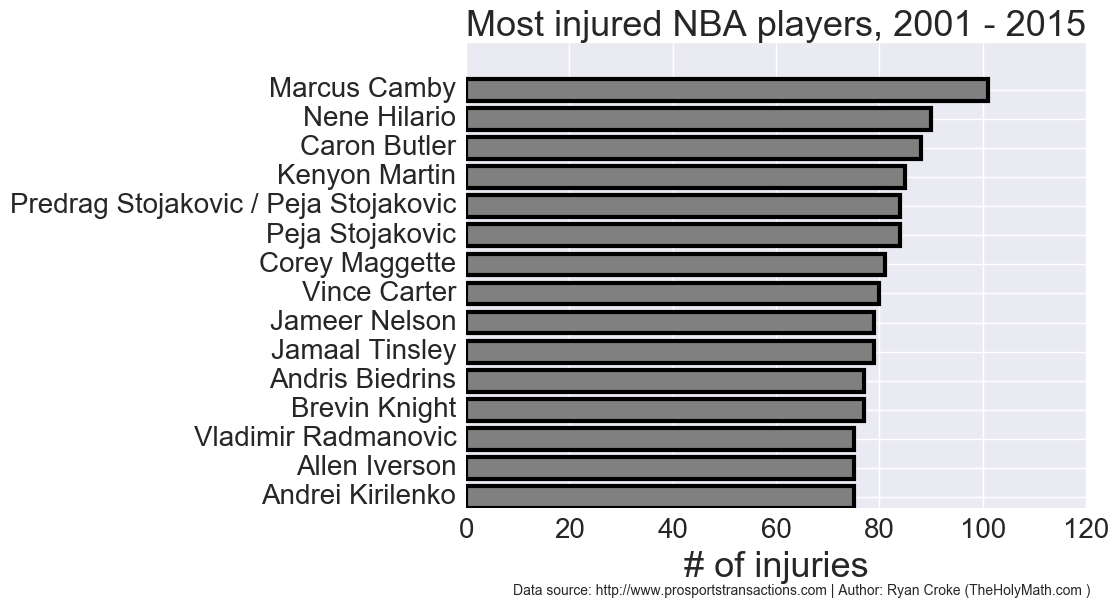

In [11]:
fig = plt.figure(figsize=(8, 6), dpi=80)

ind = np.arange(N)  # the y locations for the groups
width = 0.75       # the width of the bars
#plt.ylabel("Players", fontsize=26)  
plt.xlabel("# of injuries", fontsize=26) 

# Let's plot some results
#fig = matplotlib.pyplot.gcf()
#plt.bar(range(len(counter)), counter.values(), align='center')
barh(ind,injuries[::-1],width,color='grey',linewidth=3)
#plt.bar(ind, yearly[4].values(), width,color='grey')
#plot(xrange(3))
#plt.xticks(range(len(counter)), counter.keys())
plt.yticks(ind+width/2, players[::-1],rotation='horizontal',fontsize=20)
plt.xticks(fontsize=20)

plt.title("Most injured NBA players, 2001 - 2015", fontsize=26)
text(9, -3, "Data source: http://www.prosportstransactions.com | "  "Author: Ryan Croke (TheHolyMath.com )", fontsize=10) 
plt.savefig('most_injured.png', bbox_inches='tight')
plt.show()

In [12]:
df['injury_area'].value_counts()

knee                                  3029
ankle                                 2560
back                                  1487
foot                                  1016
returned to lineup                     924
hamstring                              682
ill                                    627
groin                                  585
shoulder                               535
unknown                                487
flu                                    443
hip                                    421
calf                                   392
rest                                   366
wrist                                  321
finger                                 251
elbow                                  238
hand                                   232
thumb                                  229
toe                                    229
concussion                             210
quadricep                              176
patella                                173
thigh      

In [13]:
df[df['injury_area']=='unknown'][400:]

,aquired,date,notes,relinquished,team,injury_area
13944,NaN,2013-12-16,skin infection (DNP),Michael Carter-Williams,76ers,unknown
14008,NaN,2013-12-21,dental procedure (DNP),Kawhi Leonard,Spurs,unknown
14058,NaN,2013-12-29,upper respiratory inflammation (DNP),Pau Gasol,Lakers,unknown
14069,NaN,2013-12-31,surgery to repair torn pectoracl muscle (out f...,Al Horford,Hawks,unknown
14071,NaN,2013-12-31,nerve root irritation (DNP),Steve Blake,Lakers,unknown
14165,NaN,2014-01-11,inflammation (DNP),Beno Udrih,Knicks,unknown
14417,NaN,2014-02-05,cervical strain (DNP),Jordan Hill,Lakers,unknown
14467,NaN,2014-02-10,fractured right orbital bone (DNP),Larry Sanders,Bucks,unknown
14468,NaN,2014-02-10,conditioning (DNP),O.J. Mayo,Bucks,unknown
14487,NaN,2014-02-12,fractured right orbital bone (DNP),Larry Sanders,Bucks,unknown


In [15]:
# group by players
g = df.groupby('relinquished')

# let's answer the question, what are common injuries that follow another injury? Is is predictive?


In [38]:
player_injury_type = {}
for name,group in g:
    injury_history = []
    for area in group['injury_area']:
        if area == 'unknown':
            continue
        elif len(injury_history) < 1:
            injury_history.append(area)
        elif area != injury_history[-1]:
            injury_history.append(area)
        else:
            continue
    player_injury_type[name] = injury_history

In [39]:
player_injury_type

{'Alan Henderson': ['knee', 'back'],
 'John Wallace': ['flu', 'knee'],
 'J.J. Hickson': ['back', 'knee'],
 'Don Nelson': ['rotator cuff'],
 'Jahidi White': ['viral infection',
  'shoulder',
  'ankle',
  'quadricep',
  'finger',
  'knee',
  'bone bruise',
  'shoulder',
  'neck',
  'shoulder',
  'ill'],
 'Jimmer Fredette': ['stomach'],
 'Roger Mason Jr.': ['shoulder', 'finger'],
 'Dante Exum': ['knee'],
 'Wayne Simien': ['knee'],
 'Gorgui Dieng': ['concussion'],
 'Kirk Snyder': ['hamstring', 'hand'],
 'Acie Law': ['ankle', 'knee', 'ankle', 'wrist', 'quadricep', 'back', 'wrist'],
 'Clarence Weatherspoon': ['foot', 'oral surgery', 'calf', 'ankle'],
 'Trevor Ariza': ['knee',
  'hip',
  'flu',
  'knee',
  'ankle',
  'abductor',
  'groin',
  'ill',
  'ankle',
  'calf',
  'knee',
  'flu',
  'knee',
  'hamstring',
  'back'],
 'Monty Williams': ['knee', 'bone bruise', 'knee'],
 'Jiri Welsch': ['quadricep'],
 'Antonio Davis': ['knee', 'rib', 'knee', 'groin', 'knee', 'back'],
 'Danny Ainge': ['ear

In [117]:
injury_followed_by_injury = dict.fromkeys(types)
for player in player_injury_type.keys():
    
    # if only 1 injury lose him
    if len(player_injury_type[player]) < 2:
        continue
        
    inj_list = player_injury_type[player]
    for i,injury in enumerate(inj_list):
        for next_inj in inj_list[i+1:]:
            if injury_followed_by_injury[injury] == None:
                injury_followed_by_injury[injury] = {next_inj:1}
            else:
                if next_inj in injury_followed_by_injury[injury].keys():
                #print("hello",next_inj,player)
                #print(injury_followed_by_injury[injury])
                    injury_followed_by_injury[injury][next_inj] += 1
                    print(injury_followed_by_injury[injury][next_inj])
                else:
                    injury_followed_by_injury[injury][next_inj] = 1


2
3
2
2
2
2
2
2
2
3
2
3
2
2
2
2
2
2
3
3
2
4
2
2
3
2
2
3
3
2
2
2
3
2
2
3
4
4
2
2
3
5
2
4
3
5
2
4
2
2
3
4
3
2
2
2
2
5
2
6
2
4
2
4
6
3
5
5
2
2
4
6
2
7
8
3
9
7
2
4
10
8
3
2
9
5
2
2
6
11
5
7
2
3
4
2
4
2
2
7
2
3
2
6
8
2
2
12
2
2
2
3
3
4
2
5
2
6
3
7
2
3
4
2
5
4
6
3
7
3
2
2
3
2
4
2
5
4
2
4
2
8
5
9
5
3
10
2
4
4
3
4
5
2
2
3
2
6
11
6
5
12
3
5
6
3
2
4
2
2
7
7
13
4
6
8
3
6
2
2
4
5
7
9
2
14
8
2
2
5
8
2
5
2
2
5
3
2
6
4
6
3
2
3
7
2
7
8
8
3
9
2
9
2
10
2
2
2
2
2
3
2
2
3
2
3
4
4
3
5
5
2
6
8
6
9
3
5
15
4
2
4
10
6
2
9
16
3
11
17
12
3
18
3
13
5
14
3
2
7
2
2
2
2
2
8
2
3
9
4
3
10
5
2
6
2
3
2
2
4
3
2
2
2
5
3
6
3
4
7
2
8
3
2
4
2
2
2
2
5
3
6
3
4
7
2
8
5
3
9
3
6
13
4
4
5
3
10
2
14
11
15
6
12
6
16
3
4
17
2
3
2
6
2
2
4
2
7
5
8
3
6
3
9
2
10
6
3
3
3
7
4
2
4
5
3
7
4
8
8
9
6
9
2
10
2
2
4
11
2
2
6
4
5
15
4
2
7
5
10
19
5
16
20
17
6
21
4
18
2
2
7
19
4
3
3
2
2
3
6
4
3
7
4
3
8
5
4
6
2
3
2
2
3
2
4
3
3
5
3
6
2
11
4
2
3
5
2
7
3
12
8
13
6
9
4
14
2
2
3
15
2
2
7
2
5
8
4
13
3
18
14
19
9
15
7
20
4
2
5
21
2
3
2
2
2
3
3
3
4
5
2
2
2
3

In [121]:
injury_followed_by_injury['knee']

{'abdominal': 31,
 'abductor': 15,
 'adductor': 13,
 'ankle': 592,
 'back': 364,
 'bone bruise': 43,
 'bronchitis': 8,
 'calf': 138,
 'cheek': 4,
 'chest': 11,
 'cold': 3,
 'collarbone': 2,
 'concussion': 43,
 'corneal': 2,
 'ear': 15,
 'elbow': 66,
 'eye': 23,
 'face': 1,
 'finger': 106,
 'flu': 181,
 'food poisoning': 13,
 'foot': 163,
 'gastroenteritis': 4,
 'groin': 128,
 'hamstring': 174,
 'hand': 72,
 'headache': 24,
 'heel': 25,
 'hernia': 11,
 'hip': 164,
 'ill': 265,
 'knee': 693,
 'leg': 44,
 'neck': 36,
 'nose': 17,
 'patella': 86,
 'pectoral': 6,
 'pinched nerve': 4,
 'pneumonia': 4,
 'quadricep': 71,
 'respiratory infection': 14,
 'rest': 291,
 'rib': 50,
 'rotator cuff': 16,
 'shin': 27,
 'shoulder': 176,
 'sinus infection': 14,
 'sinusitis': 1,
 'sternum': 5,
 'stomach': 73,
 'strep throat': 16,
 'tailbone': 3,
 'thigh': 52,
 'thumb': 66,
 'tibia': 12,
 'toe': 50,
 'tonsilitis': 2,
 'tooth extraction': 1,
 'tricep[s]': 7,
 'undisclosed': 22,
 'viral infection': 5,
 'viru

In [59]:
test = {}
test['stomach'] = {'knee':12,'knees':14}
test['groin'] = {'flu':34,'wrist':24}
test['concussion'] = {}

In [65]:
if 'kneesdf' in test['concussion'].keys():
    print("true")

In [115]:
test['groin']['f'] = 12